Instead of latent code as input to transnet, use first image instead.

In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random as rand
import copy
import matplotlib.pyplot as plt

In [245]:
class Disentangler(nn.Module): 
    def __init__(self,encoder,decoder, transnet):
        super(Disentangler,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transnet = transnet #estimates trans parameters, contains exponential weights, creates matrices
        
    def forward(self,x, x0 = None, latent_rep=None):
        if x0 == None:
            y = self.encoder(x)
            s = torch.zeros(x.size(0), self.encoder.latent_dim)
        else:
            y, s = self.transnet(x, x0, latent_rep)
        z = self.decoder(y)
        return z,y,s

class Encoder(nn.Module):
    def __init__(self, og_dim, latent_dim): #if images are nXn, og_dim = n^2.
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        super(Encoder,self).__init__()
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(og_dim, max(latent_dim, og_dim//4))
        self.fc2 = nn.Linear(max(latent_dim, og_dim//4), max(latent_dim, og_dim//16))
        self.fc3 = nn.Linear(max(latent_dim, og_dim//16), latent_dim)
    
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):  
    def __init__(self, og_dim, latent_dim):
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        super(Decoder,self).__init__()
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim, max(latent_dim, og_dim//16))
        self.fc2 = nn.Linear(max(latent_dim, og_dim//16), max(latent_dim, og_dim//4))
        self.fc3 = nn.Linear(max(latent_dim, og_dim//4), og_dim)
    
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x
    
class Transnet(nn.Module):
    def __init__(self, og_dim, latent_dim, trans_dim):
        super(Transnet,self).__init__()
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        assert trans_dim <= latent_dim, 'translation dimension must be subspace'
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.trans_dim = trans_dim
        ttl_dim = 2*og_dim + latent_dim
        self.ttl_dim = ttl_dim
        self.fc1 = nn.Linear(ttl_dim, max(latent_dim, ttl_dim//8))
        self.fc2 = nn.Linear(max(latent_dim, ttl_dim//8), max(latent_dim, ttl_dim//32))
        self.fc3 = nn.Linear(max(latent_dim, ttl_dim//32), max(latent_dim, ttl_dim//256))
        self.fc4 = nn.Linear(max(latent_dim, ttl_dim//256), trans_dim)
        
    def forward(self,x,x0,latent_rep):
        x1 = torch.cat((x,x0,latent_rep),dim = 1) #create (B, 2N+M) tensor
        x1 = self.fc1(x1)
        x1 = F.relu(x1)
        x1 = self.fc2(x1)
        x1 = F.relu(x1)
        x1 = self.fc3(x1)
        x1 = F.relu(x1)
        x1 = self.fc4(x1)
        trans = torch.cat((x1,torch.zeros(x.size(0),self.latent_dim - self.trans_dim).to(device)), dim = 1)
        latent_rep = latent_rep + trans
        return latent_rep, x1
        
class Autoencoder(nn.Module): 
    def __init__(self,encoder,decoder):
        super(Autoencoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self,x, x0=None):    
        x=self.encoder(x)
        x = self.decoder(x)
        return x
   

In [246]:
def make_model(og_dim, latent_dim, trans_dim):
    enc = Encoder(og_dim, latent_dim)
    dec = Decoder(og_dim, latent_dim)
    trans = Transnet(og_dim, latent_dim, trans_dim)
    model = Disentangler(enc,dec,trans)
    return model

def make_autoenc(og_dim,latent_dim):
    enc = Encoder(og_dim, latent_dim)
    dec = Decoder(og_dim, latent_dim)
    model = Autoencoder(enc,dec)
    return model


In [247]:
def train(print_interval, model, device, train_loader, optimizer, epoch, movie_len, transform_set, beta = .7, sparse_par = 1e-2, opt_interval = 6): #transforms is 
    model.train()
    for epoch in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            B = data.size(0)
            if movie_len != 1:    
                if batch_idx % opt_interval == 0:
                    for param in model.parameters():
                        param.requires_grad = False
                    for param in model.transnet.parameters():
                        param.requires_grad = True

                else:
                        for param in model.parameters():
                            param.requires_grad = True
                        for param in model.transnet.parameters():
                            param.requires_grad = False
            loss = 0
            optimizer.zero_grad()
            for i in range(movie_len):
                if i == 0:
                    transform = rand.choice(transform_set)
                    prev_frame = curr_frame = data
                    curr_frame = curr_frame.flatten(1).to(device)
                    output, latent_rep, trans_par = model(curr_frame)
                    first_frame = curr_frame
#                     latent_rep = latent_rep.detach().clone()
#                     latent_rep = latent_rep.to(device)
                else:
                    curr_frame = transform(prev_frame)
                    prev_frame = curr_frame
                    curr_frame = curr_frame.flatten(1).to(device)
                    output, _ , trans_par = model(curr_frame, first_frame, latent_rep)
                loss = loss + (beta**i)*(F.mse_loss(output, curr_frame) + sparse_par*1/B*torch.norm(trans_par,1))
            loss.backward()
            optimizer.step()
            
            if batch_idx % opt_interval == 0:
                for param in model.parameters():
                    param.requires_grad = True
                for param in model.transnet.parameters():
                    param.requires_grad = False

            if batch_idx % print_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

def train_enc(print_interval, model, device, train_loader, optimizer, epoch, movie_len, transform_set): #transforms is 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(movie_len):
            optimizer.zero_grad()
            if i == 0:
                prev_frame =  curr_frame = data
                transform = rand.choice(transform_set)
                curr_frame = curr_frame.flatten(1).to(device)
            else:
                curr_frame = transform(prev_frame)
                prev_frame = curr_frame
                curr_frame = curr_frame.flatten(1).to(device)
            output = model(curr_frame)
            loss = F.mse_loss(output, curr_frame)# + torch.norm(trans_par,1)
            loss.backward()
            optimizer.step()

        if batch_idx % print_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [328]:
def test(model, device, test_loader, movie_len, transform_set, choice = None):
    model.eval()
    data, _ = next(iter(test_loader))
    dim = data.size(-1)
    out_frames = torch.zeros(batch_size, movie_len, dim**2)
    true_frames = torch.zeros(batch_size,movie_len,dim,dim)
    for i in range(movie_len):
        if i == 0:
            if choice == None:
                transform = rand.choice(transform_set)
            else:
                transform = transform_set[choice]
            prev_frame = curr_frame = data
            true_frames[:,i,:,:] = curr_frame.squeeze(1)
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,i,:], latent_rep, _ = model(curr_frame)
            first_frame = curr_frame
    #         latent_rep = latent_rep.detach().clone()
    #         latent_rep = latent_rep.to(device)
        else:
            curr_frame = transform(prev_frame)
            true_frames[:,i,:,:] = curr_frame.squeeze(1)
            prev_frame = curr_frame
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,i,:], _ , _ = model(curr_frame, first_frame, latent_rep)

    out_frames = out_frames.reshape(batch_size,movie_len,dim,dim)
    out_frames = out_frames.detach()
    
    return true_frames, out_frames

In [266]:
def onepar_sg_test(model, device, test_loader, num_step, sg_dim, sg_rate = .1):
    #remember, the transformation dimenions are the first k dimensions of the latent rep
    model.eval()
    data, _ = next(iter(test_loader))
    dim, batch_size = data.size(-1), data.size(0)
    out_frames = torch.zeros(batch_size, 2*num_step+1, dim**2)
    assert model.encoder.latent_dim >= sg_dim , 'given subgroup dimension index larger than latent dimension'
    ix = sg_dim*torch.ones(batch_size)
    sg_velocity = sg_rate*F.one_hot(ix.long(), model.encoder.latent_dim)
    sg_velocity = sg_velocity.to(device)
    for i in range(num_step+1):
        if i == 0:
            curr_frame = data
            curr_frame = curr_frame.flatten(1).to(device)
            out_frames[:,num_step,:], latent_rep, _ = model(curr_frame)
            lr_neg = latent_rep
            lr_pos = latent_rep
        else:
            lr_pos = lr_pos + i*sg_velocity
            out_frames[:,num_step+i,:] = model.decoder(lr_pos)
            lr_neg = lr_neg - i*sg_velocity
            out_frames[:, num_step-i,:] = model.decoder(lr_neg)

    out_frames = out_frames.reshape(batch_size,2*num_step+1,dim,dim)
    out_frames = out_frames.detach()
    
    return out_frames

# Data Loader

In [249]:
hor_trans = transforms.Compose(
    [transforms.RandomAffine(0, translate = (.3,0))])

ver_trans = transforms.Compose(
    [transforms.RandomAffine(0,translate = (0,.3))])


transform_set = [hor_trans,ver_trans]

In [256]:
loader_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: torch.clamp(x, min = 0)),
     transforms.Lambda(lambda x: x/torch.amax(x))
     ]
)
batch_size = 40
movie_len = 3
#(Down)Load MNIST
data_set = datasets.MNIST(root='./data', train=True, download=False, transform=loader_transform)
test_set = datasets.MNIST(root='./data', train=False, download=False, transform=loader_transform)

#Create data loader
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)


# 2D Translation

In [257]:
model_dis = make_model(28**2, latent_dim= 16, trans_dim = 2)

In [258]:
# model_dis = make_autoenc(28**2, latent_dim= 16)

In [259]:
device = torch.device(1)
torch.cuda.set_device(1)
model_dis = model_dis.to(device)
optimizer = torch.optim.Adam(model_dis.parameters(), lr=1e-3) #e-1


In [260]:
#empirically, sparse_par should be on order of 1e-3. Set it to 1e-2 and trans_net learned just identity transform.

In [262]:
train(300, model_dis, device, data_loader, optimizer, epoch = 10, movie_len = movie_len, transform_set = transform_set, sparse_par = 5e-4, opt_interval = 3, beta = .85)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.066906
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.054208
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.078969
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.079561
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.075760
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.082266
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.085300
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.082499
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.074826
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.055997
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078339
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.087113
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.070784
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.084216
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.081352


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [263]:
true_frames, out_frames = test(model_dis, device, test_loader, movie_len, transform_set)

In [392]:
os.getcwd()

'/home/shazoop/form_motion_NN'

In [395]:
# torch.save(model_dis.state_dict(), '/home/shazoop/form_motion_NN/local_chart_pics/2d_translation_091621/model_par_091621')

In [264]:
# def plot_ex(num_ex,true_frames, out_frames, limit_ex = 30):
#     movie_len = true_frames(1)
#     assert num_ex % movie_len == 0 , 'number of examples must be multiple of movie length'
#     fig = plt.figure(figsize=(30,30)) #image sequence from dataset
#     for i in range(movie_len*limit_ex):
#             fig.add_subplot(2*limit_ex,3,i+1)
#             plt.imshow(true_frames[ix,i],cmap = "Greys")
#             fig.add_subplot(2,3,i+4)
#             plt.imshow(out_frames[ix,i], cmap = 'Greys')

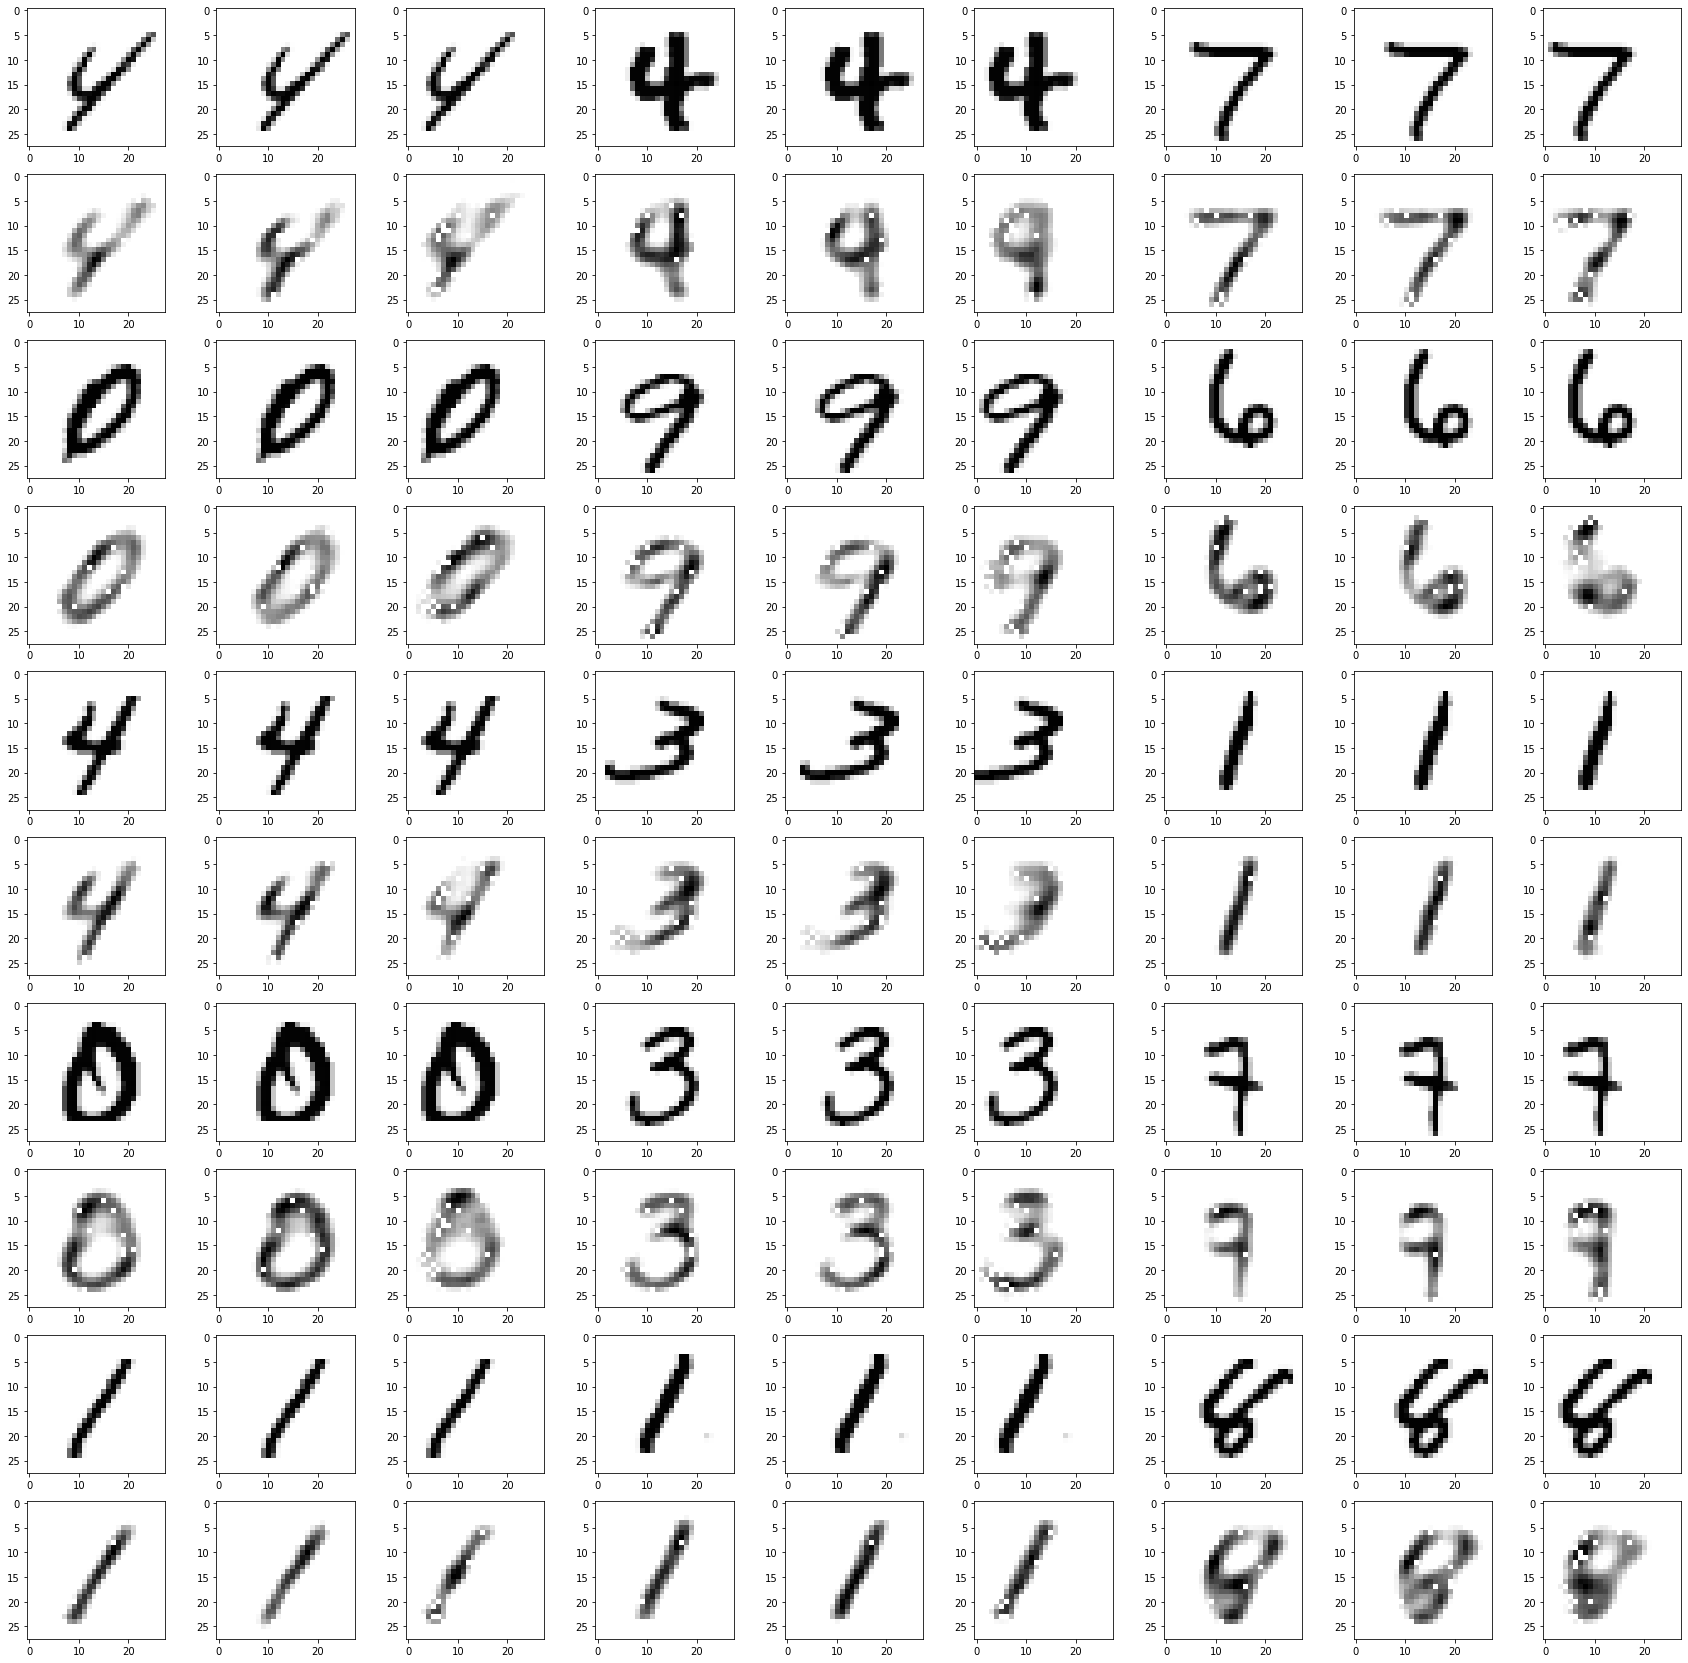

In [272]:
fig = plt.figure(figsize=(30,30)) #image sequence from dataset
for i in range(45):
        fig.add_subplot(10,9,i+9*(i//9)+1)
        plt.imshow(true_frames[i//3,i % 3],cmap = "Greys")
        fig.add_subplot(10,9,i+9*(i//9)+10)
        plt.imshow(out_frames[i//3,i % 3], cmap = 'Greys')
# plt.hist(true_frames[ix,0],bins=4)
# plt.hist(true_frames[ix,1], bins=4)
plt.savefig('True vs Reconstruction')

In [267]:
num_step = 4
sg_out_frames = onepar_sg_test(model_dis, device, test_loader, num_step = num_step, sg_dim = 1, sg_rate = .075)

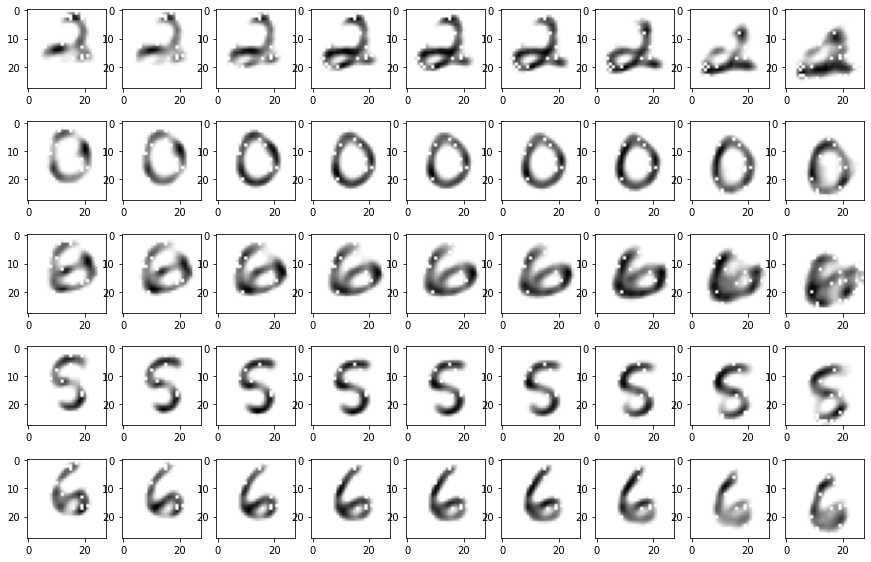

In [273]:
fig = plt.figure(figsize=(15,10)) #image sequence from dataset
for i in range(45):
        fig.add_subplot(5,9,i+1)
        plt.imshow(sg_out_frames[i//9,i % 9],cmap = "Greys")
plt.savefig('1st sg')

In [270]:
sg_out_frames2 = onepar_sg_test(model_dis, device, test_loader, num_step = num_step, sg_dim = 0, sg_rate = .1)

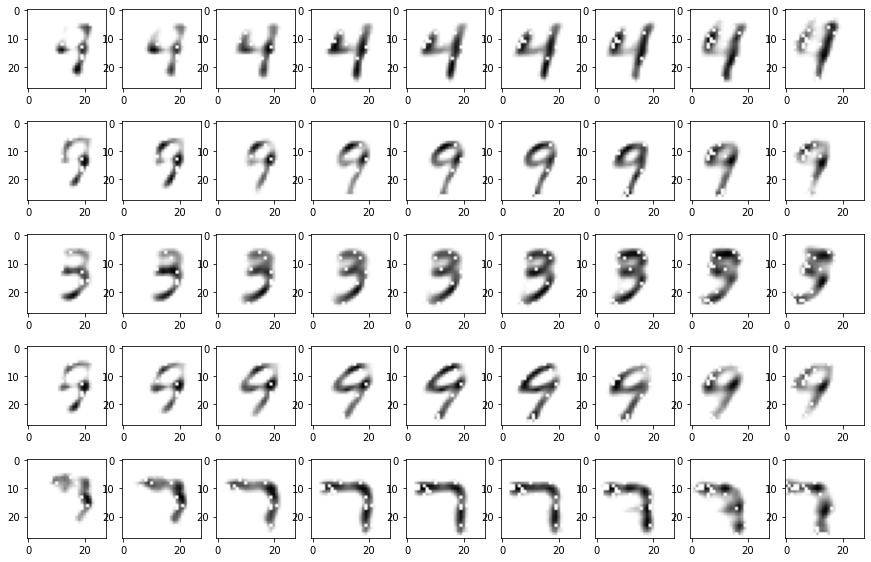

In [274]:
fig = plt.figure(figsize=(15,10)) #image sequence from dataset
for i in range(45):
        fig.add_subplot(5,9,i+1)
        plt.imshow(sg_out_frames2[i//9,i % 9],cmap = "Greys")
plt.savefig('2nd sg')

# Rotation and 1-D translation

In [355]:
hor_trans = transforms.Compose(
    [transforms.RandomAffine(0, translate = (.3,0))])

rot_trans = transforms.Compose(
(    [transforms.RandomAffine(degrees = (30,60))]))

transform_set2 = [hor_trans,rot_trans]

In [356]:
model_dis2 = make_model(28**2, latent_dim= 16, trans_dim = 2)
model_dis2 = model_dis2.to(device)
optimizer2 = torch.optim.Adam(model_dis2.parameters(), lr=1e-3) #e-1

In [357]:
train(300, model_dis2, device, data_loader, optimizer2, epoch = 10, movie_len = movie_len, transform_set = transform_set2, sparse_par = 3e-3, opt_interval = 3, beta = .85)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.237690
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.186538
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.152212
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.163982
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.142761
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.116372
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.138973
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.115703
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.128009
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.117295
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.134313
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.088729
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.114869
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.103494
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.124550
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.106919
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.097875
Train Epoch: 3 [24000/60000 (40%)]	Loss: 0.103487
Train Epoch: 3 [36000/60000 (60%)]	Loss: 0.079515
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.090730
Train Epoch: 4 [0/60

In [397]:
#torch.save(model_dis2.state_dict(), '/home/shazoop/form_motion_NN/local_chart_pics/rot_and_1dtrans_091621/model_par_091621')

In [358]:
true_frames2, out_frames2 = test(model_dis2, device, test_loader, movie_len, transform_set2, choice = 1)

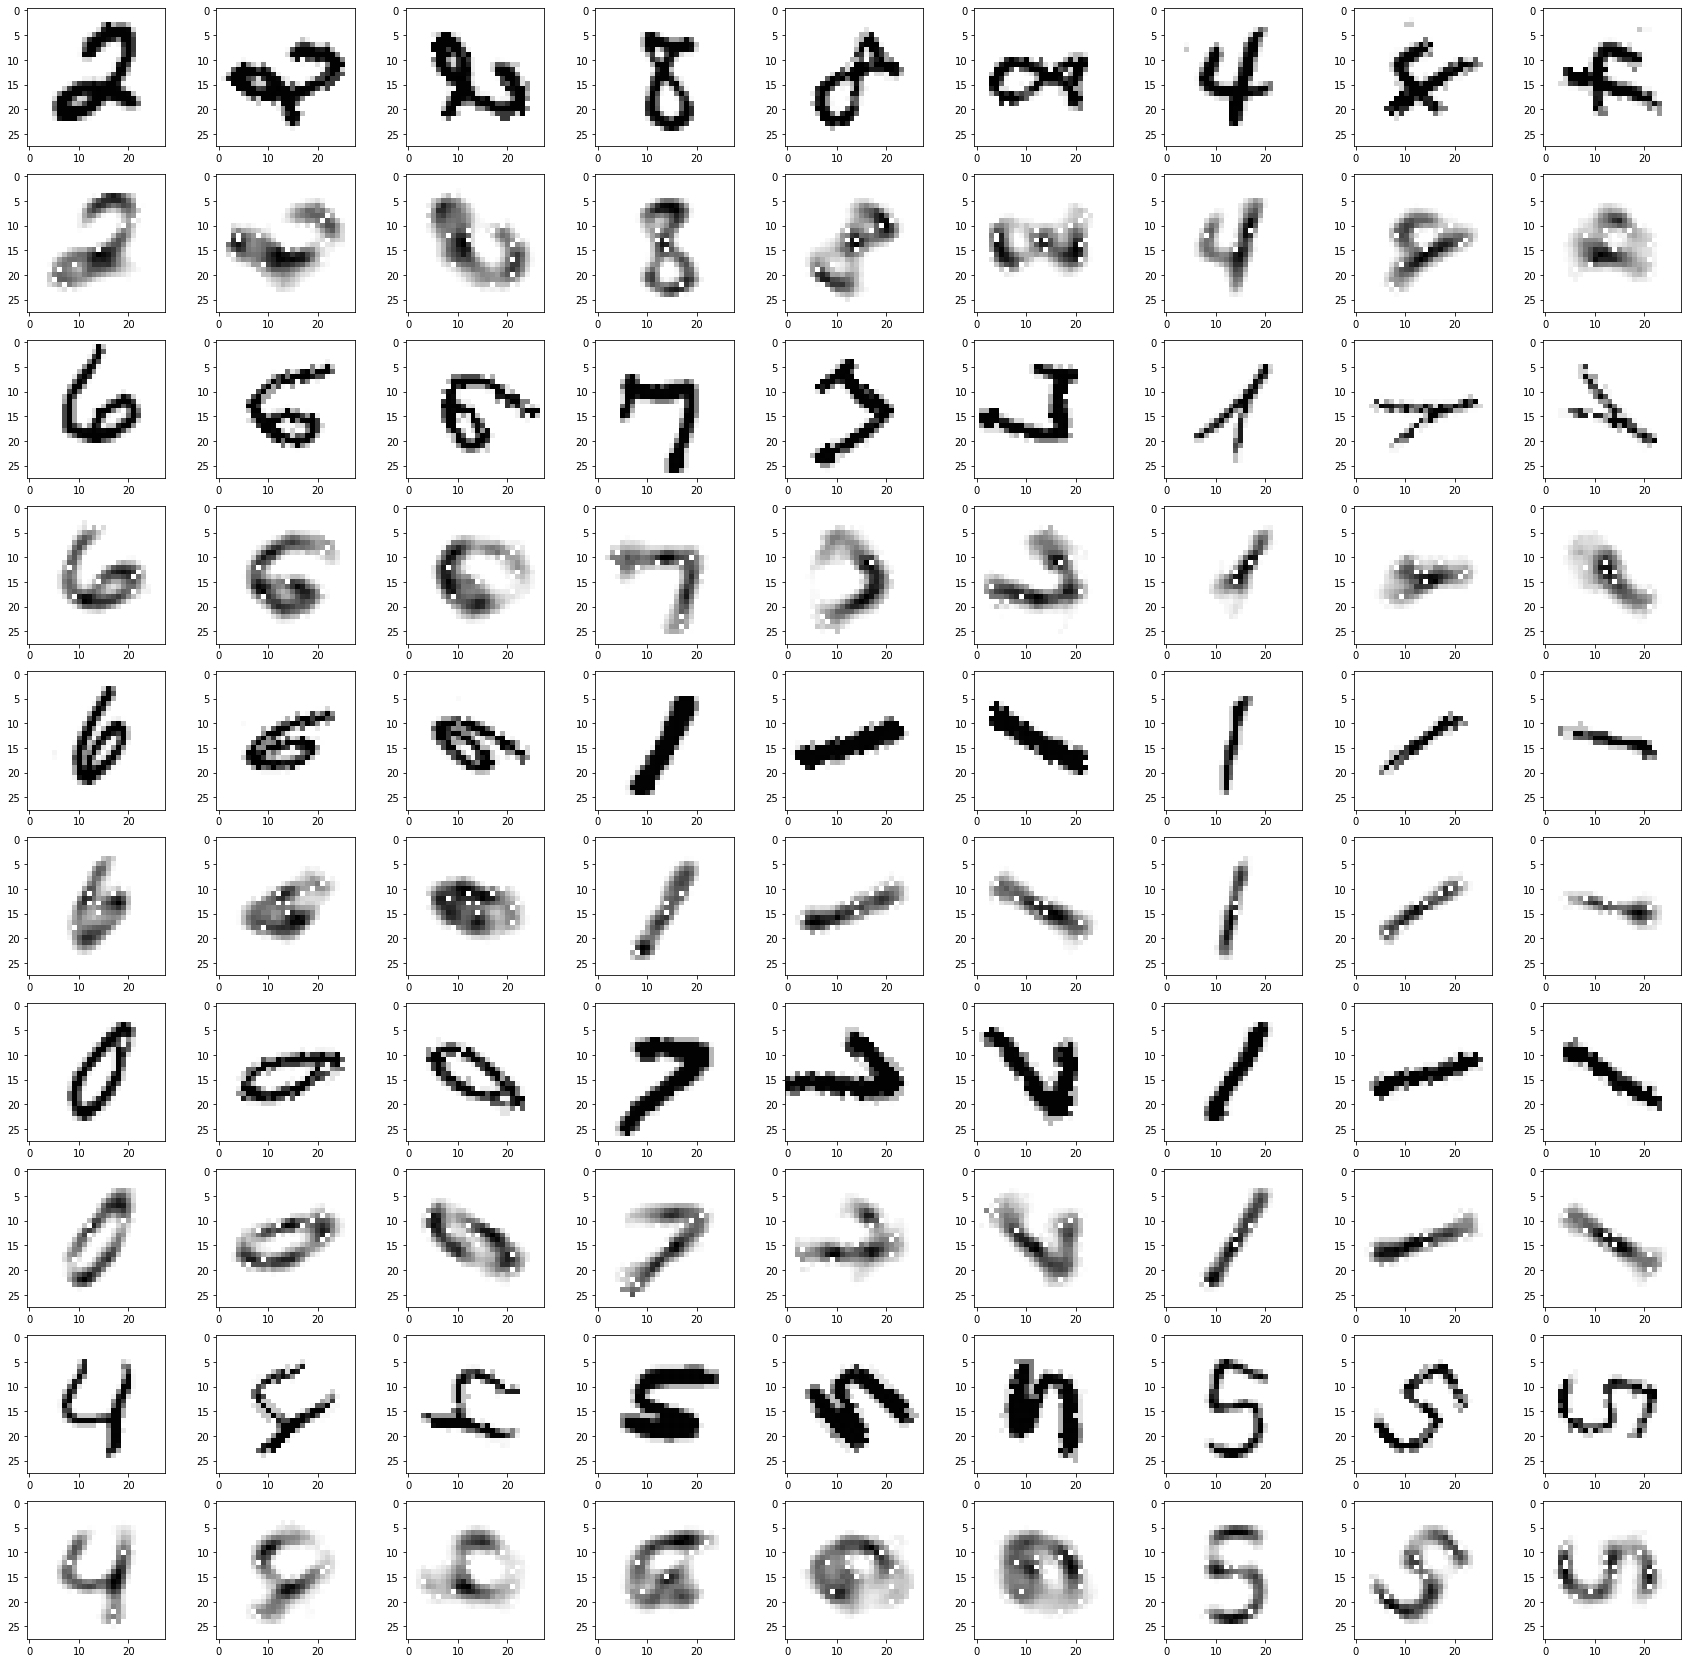

In [369]:
fig = plt.figure(figsize=(30,30)) #image sequence from dataset
for i in range(45):
        fig.add_subplot(10,9,i+9*(i//9)+1)
        plt.imshow(true_frames2[i//3,i % 3],cmap = "Greys")
        fig.add_subplot(10,9,i+9*(i//9)+10)
        plt.imshow(out_frames2[i//3,i % 3], cmap = 'Greys')
# plt.hist(true_frames[ix,0],bins=4)
# plt.hist(true_frames[ix,1], bins=4)
plt.savefig('True vs Reconstruction')

In [365]:
sg_out_frames2_1 = onepar_sg_test(model_dis2, device, test_loader, num_step = num_step, sg_dim = 1, sg_rate = .03)

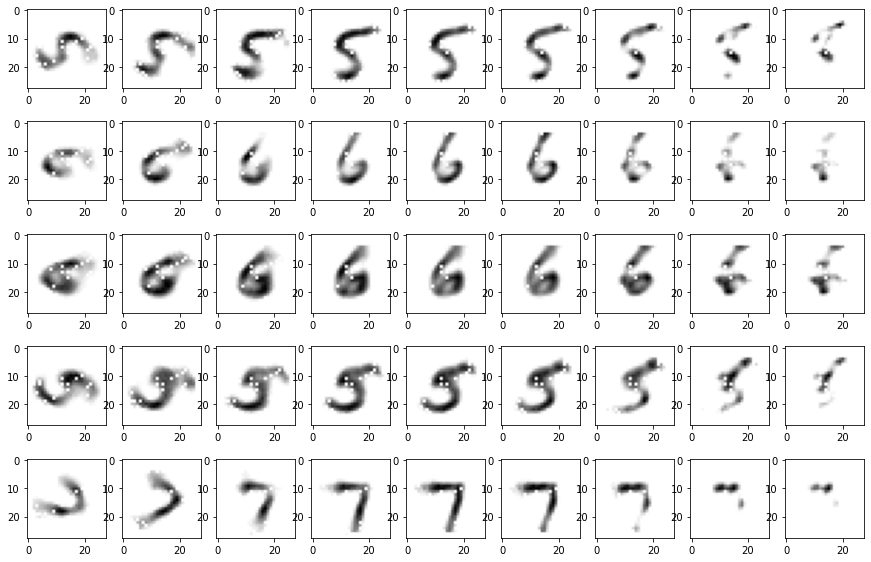

In [370]:
fig = plt.figure(figsize=(15,10)) #image sequence from dataset
for i in range(45):
        fig.add_subplot(5,9,i+1)
        plt.imshow(sg_out_frames2_1[i//9,i % 9],cmap = "Greys")
plt.savefig('1st sg')

In [367]:
sg_out_frames2_2 = onepar_sg_test(model_dis, device, test_loader, num_step = num_step, sg_dim = 0, sg_rate = .1)

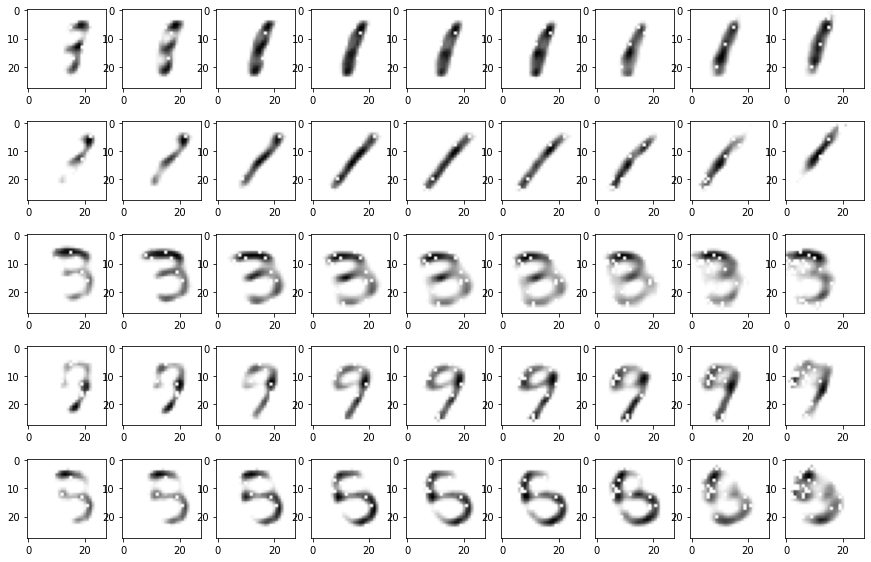

In [371]:
fig = plt.figure(figsize=(15,10)) #image sequence from dataset
for i in range(45):
        fig.add_subplot(5,9,i+1)
        plt.imshow(sg_out_frames2_2[i//9,i % 9],cmap = "Greys")
plt.savefig('2nd sg')